In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import warnings
import datetime
import itertools
from pylab import rcParams

In [112]:
full_data = pd.read_csv('full_data.csv', parse_dates=['DateTime'])

We will begin by taking a closer look at the data, some exogenous variables and decomposing the seasonality, trend and noise components

In [4]:
# creating an exogenous holiday/non-holiday variable for modelling later
full_data['holiday'] = full_data['DateTime'].dt.weekday // 5 == 1
full_data.loc[full_data['DateTime'].dt.date == datetime.date(year = 2017, month = 4, day = 21), 'holiday'] = True
full_data['holiday'] = full_data['holiday'] * 1

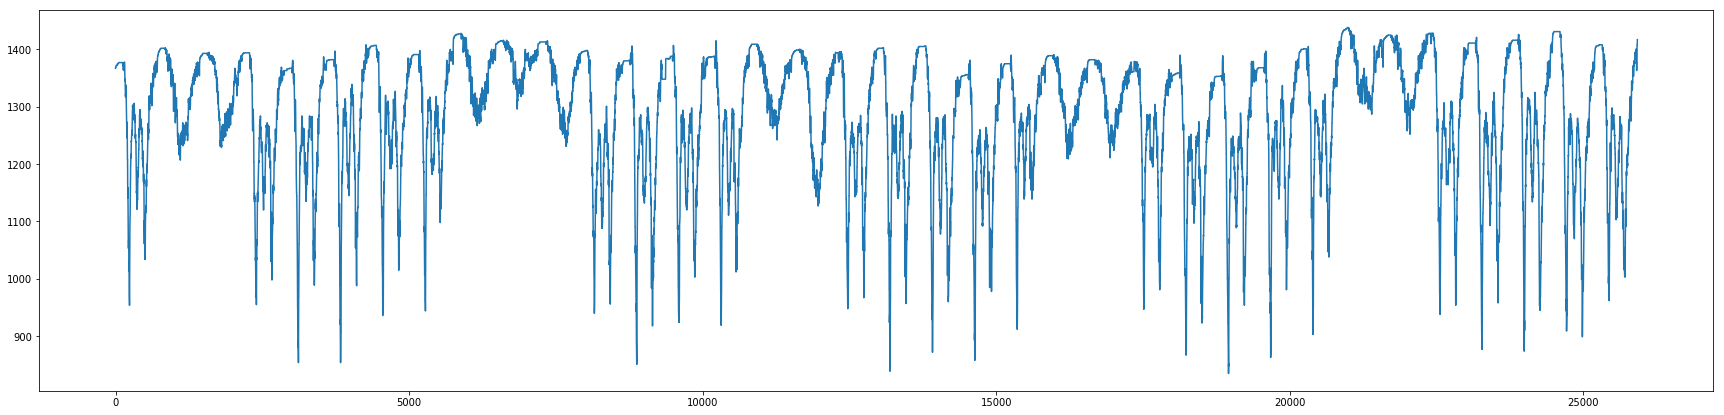

In [5]:
fig, ax = plt.subplots(figsize=(30,7))
full_data['available_bikes'].plot()
plt.show()

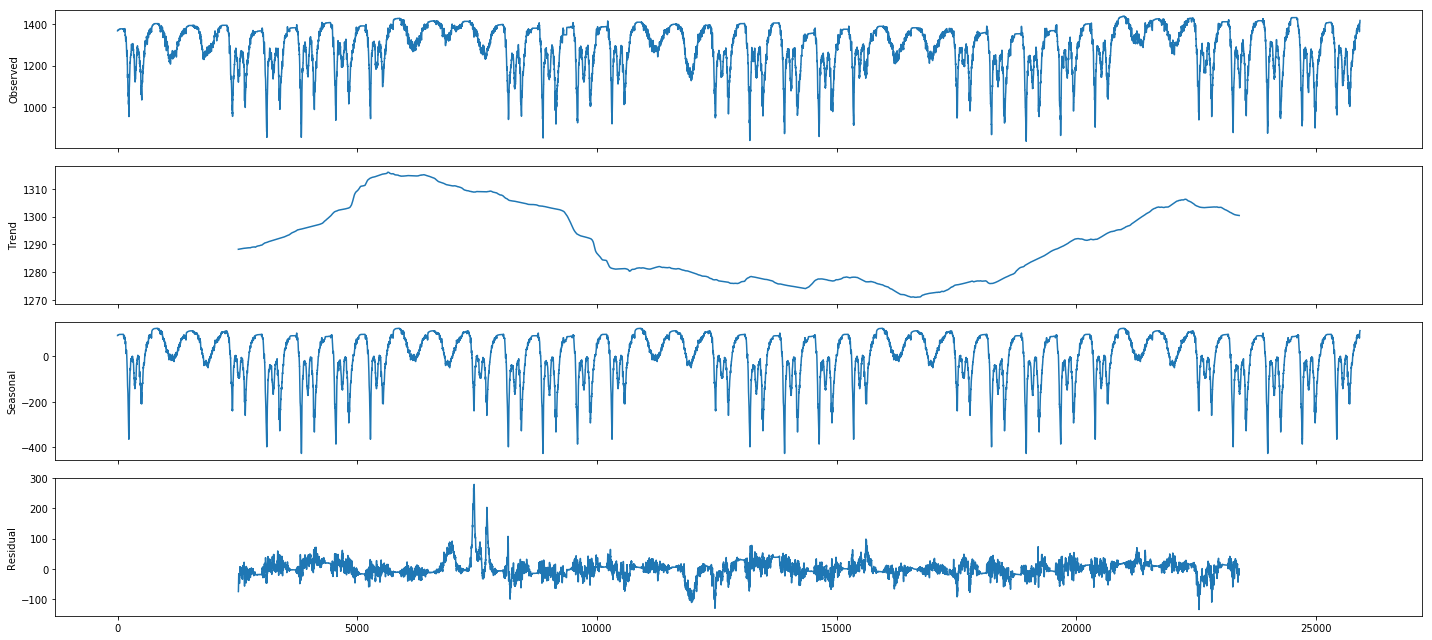

In [6]:
# lets try and decompose the time series into trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(full_data['available_bikes'], 
                                          model='additive', 
                                          freq=5040)  # weekly


old_rcParams = rcParams['figure.figsize']; rcParams['figure.figsize'] = 20, 9      
decomposition.plot()
plt.show()
rcParams['figure.figsize'] = old_rcParams 

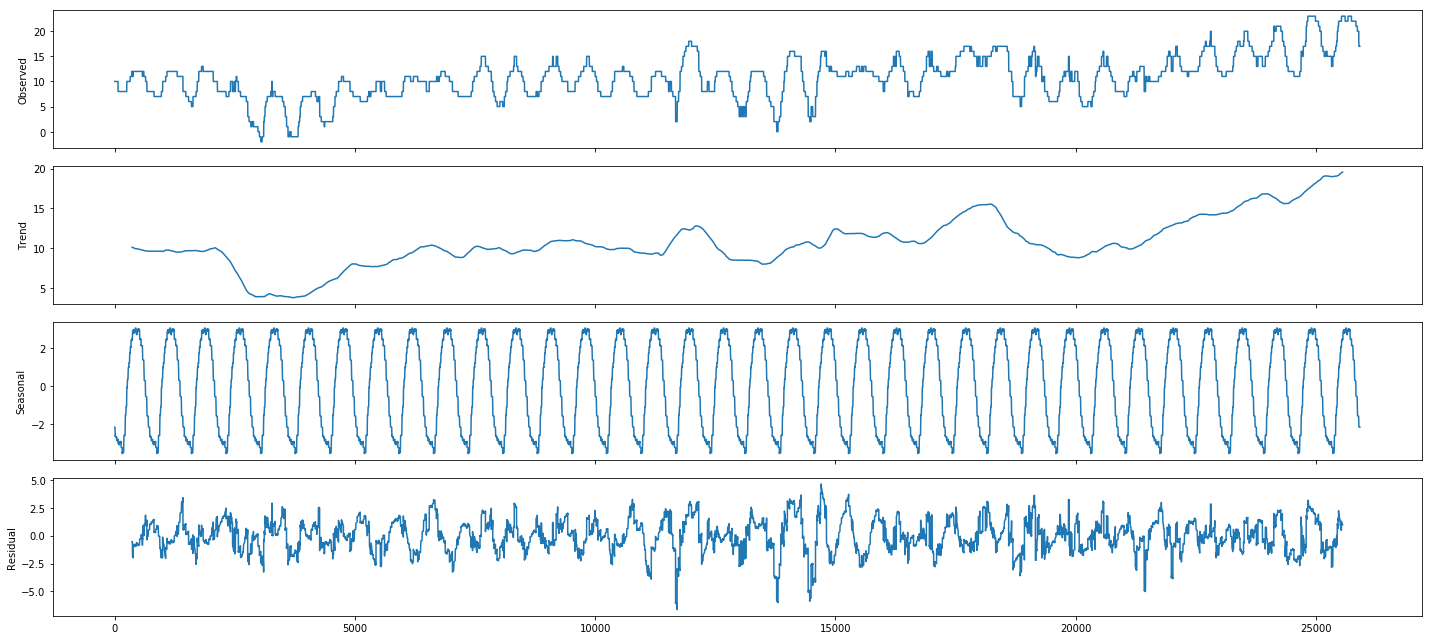

In [8]:
# lets try and decompose the temperature into trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(full_data['Temperature'], 
                                          model='additive', 
                                          freq=720)  # daily


old_rcParams = rcParams['figure.figsize']; rcParams['figure.figsize'] = 20, 9      
decomposition.plot()
plt.show()
rcParams['figure.figsize'] = old_rcParams 

It looks like we should be able to model this data pretty well, lets split the data into train and test

In [9]:
# train test split
train_frac = 0.9
train_size = int(len(full_data) * train_frac)
df_train, df_test = full_data[0:train_size], full_data[train_size:len(full_data)]

print('Observations: %d' % (len(full_data)))
print('Training Observations: %d' % (len(df_train)))
print('Testing Observations: %d' % (len(df_test)))

Observations: 25920
Training Observations: 23328
Testing Observations: 2592


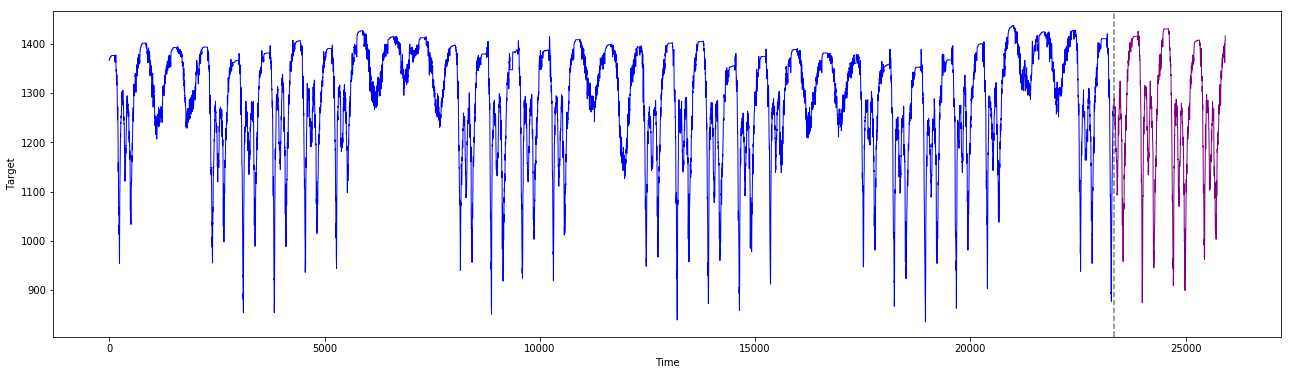

In [10]:
target_var = 'available_bikes'
plt.figure(figsize = (22,6))
plt.plot(df_train[target_var],  color = 'blue', linewidth = 1)
plt.plot(df_test[target_var], color='purple', linewidth = 1)
plt.axvline(df_test.index[0], linestyle='--', color = 'grey')
plt.xlabel('Time')
plt.ylabel('Target')
plt.show()

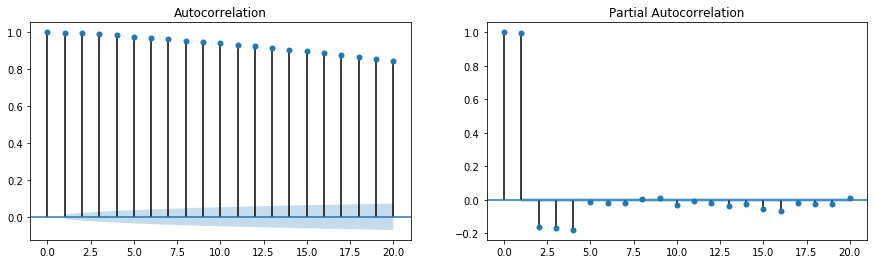

In [11]:
# auto correlation and partial auto correlation plots
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(full_data[target_var], lags=20, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(full_data[target_var], lags=20, ax=axes[1])

# Modelling

Here we meet our first modelling challenge: Since data is collected every two minutes and the seasonality is weekly we have a seasonality order of 5040 in our SARIMAX model.  Unfortunatly the state-space grows linearly (or worse) with the number of seasons so fitting with this seasonality becomes *extremely* slow.

In [12]:
# fitting this is not feasable
model = sm.tsa.statespace.SARIMAX(df_train[target_var], order=(1,0,0), seasonal_order=(0, 1, 0, 5040),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)

The alternative is to manually remove the seasonality, fit a regular ARIMA(X) and add the seasonality back into the predictions

In [13]:
# ensure our series has mean zero
series_mean = df_train[target_var].mean()
df_train[target_var] -= series_mean

/anaconda3/envs/data_generation_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# lets do another decomposition of our training set
decomposition = sm.tsa.seasonal_decompose(df_train[target_var], 
                                          model='additive', 
                                          freq=5040)  # weekly

# and pull out the trend
seasonality = decomposition.seasonal[-5040:]
trend = decomposition.trend

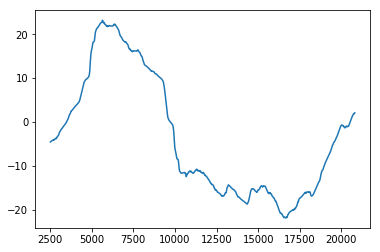

In [417]:
# this trend doesn't look stationary - looks like we will need at least one diff
trend.plot();

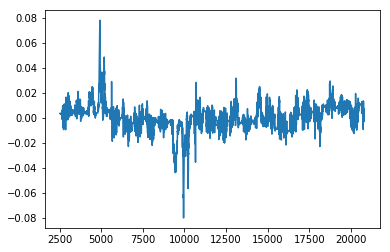

In [418]:
# after differencing things are looking better
trend.diff().plot();

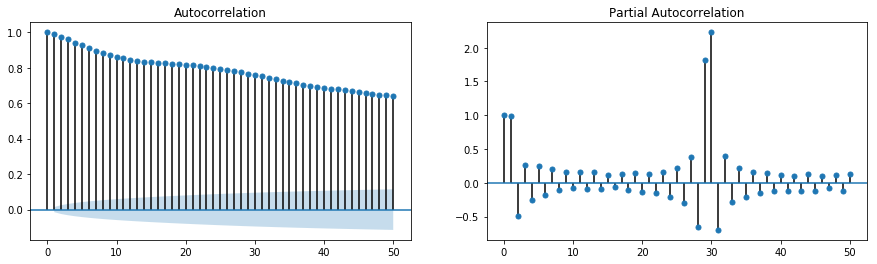

In [422]:
# auto correlation and partial auto correlation plots on the differenced trend
# looks like there is still some work to do - maybe one of our exogenous variables can help here
# an ARIMAX(1+, 1, 1+) looks appropriate, lets do a grid search to find out
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(trend.diff().dropna(), lags=50, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(trend.diff().dropna(), lags=50, ax=axes[1])

In [34]:
# grid search across reasonable ARIMA parameters and exogenous variables
p  = q = range(0, 5)
d = range(2)

pdq = list(itertools.product(p, d, q))
exog_vars = {'None': None, 'holidays': df_train['holiday'], 'temperature': df_train['Temperature']}

warnings.filterwarnings("ignore") # specify to ignore warning messages

print('Fitting {} combinations:\n'.format(len(exog_vars)*len(pdq)))
aic_values = list()
exog_order = list()
pdq_order = list()
for param in pdq:
    for key, value in exog_vars.items():
        try:
#             mod = sm.tsa.SARIMAX(df_train[target_var], exog=value, order=param)
            mod = sm.tsa.SARIMAX(trend, exog=value, order=param)
            results = mod.fit()
            aic_values.append(results.aic)
            exog_order.append(key)
            pdq_order.append(param)
            print('ARIMA{} exog: {} - AIC:{}'.format(param, key, results.aic))
        except:
            aic_values.append(np.NAN)
            exog_order.append(key)
            pdq_order.append(param)
            print('ARIMA{} exog: {} - AIC:{}'.format(param, key, np.NAN))
            continue
        
best_params = pdq_order[aic_values.index(min(aic_values))]
exog_param = exog_order[aic_values.index(min(aic_values))]
print('\nBest Params:\nARIMA{} exog: {} - AIC:{}'.format(best_params, exog_param, min(aic_values)))

Fitting 150 combinations:

ARIMA(0, 0, 0) exog: None - AIC:149085.39301702834
ARIMA(0, 0, 0) exog: holidays - AIC:148782.1843904858
ARIMA(0, 0, 0) exog: temperature - AIC:147152.7887238256
ARIMA(0, 0, 1) exog: None - AIC:nan
ARIMA(0, 0, 1) exog: holidays - AIC:nan
ARIMA(0, 0, 1) exog: temperature - AIC:nan
ARIMA(0, 0, 2) exog: None - AIC:nan
ARIMA(0, 0, 2) exog: holidays - AIC:nan
ARIMA(0, 0, 2) exog: temperature - AIC:nan
ARIMA(0, 0, 3) exog: None - AIC:nan
ARIMA(0, 0, 3) exog: holidays - AIC:nan
ARIMA(0, 0, 3) exog: temperature - AIC:nan
ARIMA(0, 0, 4) exog: None - AIC:nan
ARIMA(0, 0, 4) exog: holidays - AIC:nan
ARIMA(0, 0, 4) exog: temperature - AIC:nan
ARIMA(0, 1, 0) exog: None - AIC:-114289.78890225478
ARIMA(0, 1, 0) exog: holidays - AIC:-114287.85118436029
ARIMA(0, 1, 0) exog: temperature - AIC:-114287.97741557441
ARIMA(0, 1, 1) exog: None - AIC:nan
ARIMA(0, 1, 1) exog: holidays - AIC:nan
ARIMA(0, 1, 1) exog: temperature - AIC:nan
ARIMA(0, 1, 2) exog: None - AIC:nan
ARIMA(0, 1, 2

In [15]:
# and fit an ARIMA to the trend component
model = sm.tsa.SARIMAX(trend, exog=df_train['Temperature'], order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())

/anaconda3/envs/data_generation_env/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:        available_bikes   No. Observations:                23328
Model:               SARIMAX(2, 1, 1)   Log Likelihood              100697.289
Date:                Mon, 16 Sep 2019   AIC                        -201384.578
Time:                        18:24:29   BIC                        -201344.291
Sample:                             0   HQIC                       -201371.495
                              - 23328                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature -1.639e-06   9.84e-07     -1.666      0.096   -3.57e-06    2.89e-07
ar.L1           0.9487      0.005    195.748      0.000       0.939       0.958
ar.L2           0.0375      0.005      7.737    

In [17]:
# now lets add back the seasonality and mean to asses the model
exog_forecast = df_test.loc[df_test.index[0]:df_test.index[-1],'Temperature']
exog_forecast = pd.DataFrame(exog_forecast)
trend_predictions = model_fit.predict(start=df_test.index[0], end=df_test.index[-1], exog=exog_forecast).reset_index(drop=True)

seasonal_predictions = seasonality[0:len(trend_predictions)].reset_index(drop=True)
centered_predictions = trend_predictions + seasonal_predictions
full_predictions = centered_predictions + series_mean
full_predictions.index = df_test.index

In [18]:
training_true = df_train[target_var] + series_mean

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(df_test[target_var], full_predictions)

2.223551827633083

Finally we can plot the results

In [265]:
# plotting parameters
num_training = 18720  # show training example n onward
num_testing = 1152  # show first n testing examples

x_labels = full_data['DateTime'][num_training:(df_train.shape[0] + num_testing)]

num_total = num_training+len(x_labels)

formatted_x_labs = [timestamp.strftime('%d-%m-%Y') for timestamp in x_labels]
x_labels_current = range(num_training, num_total)

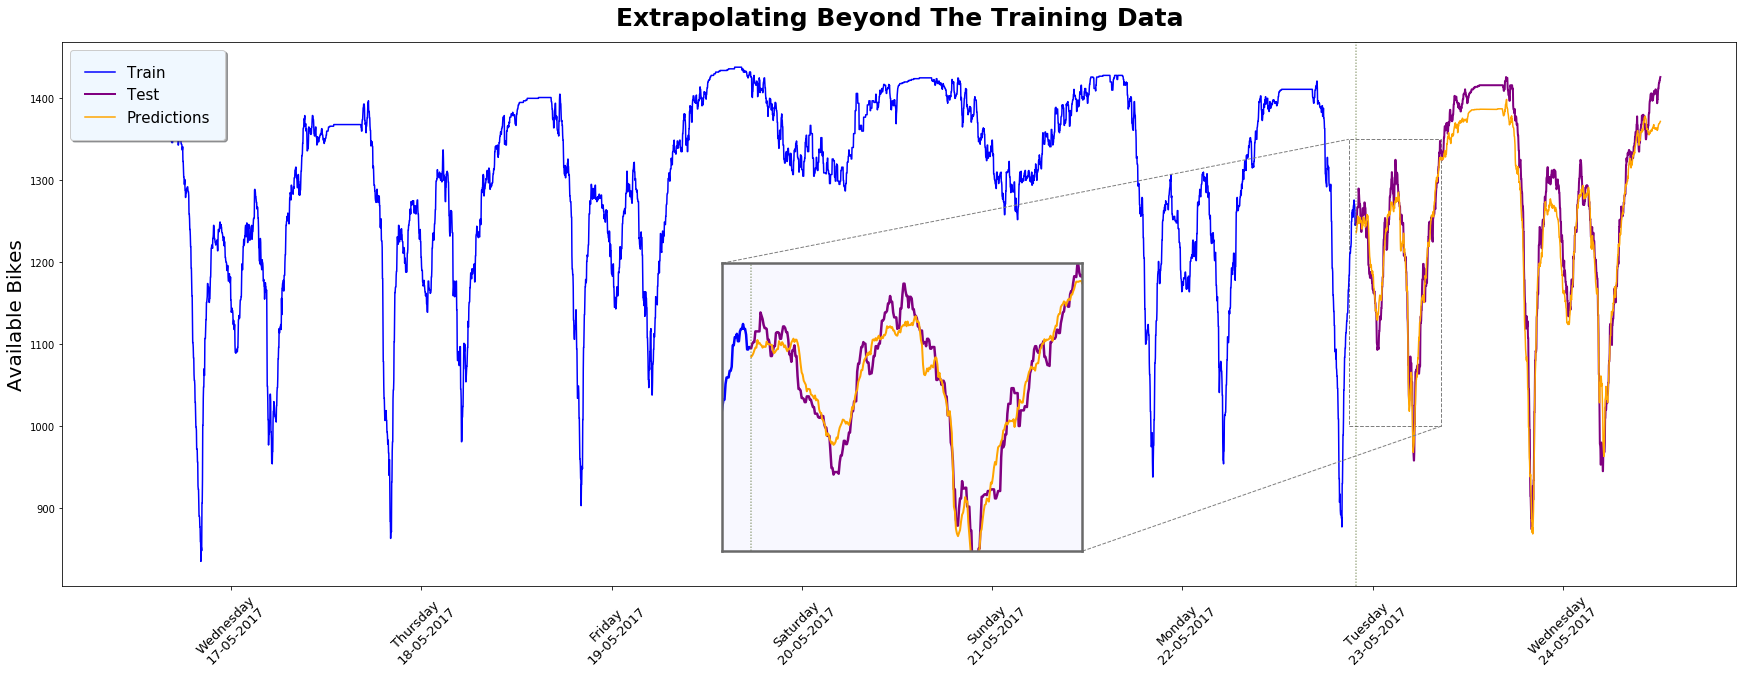

In [438]:
fig, ax = plt.subplots(figsize=(30,10))

# main plot 
ax.plot(training_true.iloc[num_training:],  color = 'blue', linewidth = 1.5, label='Train')
ax.plot(df_test[target_var].iloc[:num_testing], color='purple', linewidth = 2, label='Test')
ax.plot(full_predictions.iloc[:num_testing], color='orange', linewidth = 1.5, label='Predictions')
ax.axvline(full_predictions.index[0], linestyle=(0, (1, 1)), color = 'darkolivegreen', alpha=0.5)
plt.legend(loc='upper left', fancybox=True, framealpha=1, shadow=True, borderpad=1, facecolor='aliceblue', prop={'size': 15})
ax.set_ylabel('Available Bikes', fontsize=20)

# regular plotting params 
plt.title('Extrapolating Beyond The Training Data', y=1.02, fontsize=25, fontweight="bold")

# inset plot ivory
axins = inset_axes(ax, 5, 4, loc=3, bbox_to_anchor=(925,120), axes_kwargs={'facecolor':'ghostwhite'}) 
axins.plot(training_true.iloc[num_training:],  color = 'blue', linewidth = 2.5, label='Train')
axins.plot(df_test[target_var].iloc[:num_testing], color='purple', linewidth = 2.5, label='Test')
axins.plot(full_predictions.iloc[:num_testing], color='orange', linewidth = 2, label='Predictions')
axins.axvline(full_predictions.index[0], linestyle=(0, (1, 1)), color = 'darkolivegreen', alpha=0.5)
[i.set_linewidth(2.5) for i in axins.spines.values()]
plt.setp(axins.spines.values(), color='dimgrey')

x1, x2, y1, y2 = 23300, 23650, 1000, 1350 # specify the limits

axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=1, linestyle='--')

# x ticks
formatted_x_labs = ['{}\n{}'.format(timestamp.strftime('%A'), timestamp.strftime('%d-%m-%Y')) for timestamp in x_labels]
num_days = len(set(formatted_x_labs)) 
nth_label = len(x_labels)//(num_days)
ax.set_xticks(x_labels_current[350::nth_label])
ax.set_xticklabels(formatted_x_labs[350::nth_label], rotation=45, fontsize=13)
plt.xticks([], [])
plt.yticks([], [])

plt.savefig('visualisations/SARIMAX_predictions.png', bbox_inches='tight')
plt.show()